# Talking Points

Finding the drivers of point total from the 2014-2018 seasons

In [2]:
#acquire libraries
import pandas as pd

#explore libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from prepare import wrangle_nba, scaled_wrangle_nba
from explore import elbow_plot, run_kmeans, add_to_train

#model libraries
from model import (select_kbest, rfe, linearReg_train, 
lassoLars_train, poly_linearReg_train, linearReg_validate,
lassoLars_validate, poly_linearReg_validate)



import warnings
warnings.filterwarnings("ignore")

## Acquire

In [3]:
#uploading the nba csv and saving it as a dataframe called nba
nba = pd.read_csv('nba.games.stats.csv')

### Initial Analysis of the Data

In [4]:
#sneak peak into the data
nba.head()

,Unnamed: 0,Team,Game,Date,Home,Opponent,WINorLOSS,TeamPoints,OpponentPoints,FieldGoals,...,Opp.FreeThrows,Opp.FreeThrowsAttempted,Opp.FreeThrows.,Opp.OffRebounds,Opp.TotalRebounds,Opp.Assists,Opp.Steals,Opp.Blocks,Opp.Turnovers,Opp.TotalFouls
0,1,ATL,1,2014-10-29,Away,TOR,L,102,109,40,...,27,33,0.818,16,48,26,13,9,9,22
1,2,ATL,2,2014-11-01,Home,IND,W,102,92,35,...,18,21,0.857,11,44,25,5,5,18,26
2,3,ATL,3,2014-11-05,Away,SAS,L,92,94,38,...,27,38,0.711,11,50,25,7,9,19,15
3,4,ATL,4,2014-11-07,Away,CHO,L,119,122,43,...,20,27,0.741,11,51,31,6,7,19,30
4,5,ATL,5,2014-11-08,Home,NYK,W,103,96,33,...,8,11,0.727,13,44,26,2,6,15,29


In [5]:
#checking to see how many rows and columns there are
nba.shape

(9840, 41)

In [6]:
#checking data types, null values, and column names
nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9840 entries, 0 to 9839
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                9840 non-null   int64  
 1   Team                      9840 non-null   object 
 2   Game                      9840 non-null   int64  
 3   Date                      9840 non-null   object 
 4   Home                      9840 non-null   object 
 5   Opponent                  9840 non-null   object 
 6   WINorLOSS                 9840 non-null   object 
 7   TeamPoints                9840 non-null   int64  
 8   OpponentPoints            9840 non-null   int64  
 9   FieldGoals                9840 non-null   int64  
 10  FieldGoalsAttempted       9840 non-null   int64  
 11  FieldGoals.               9840 non-null   float64
 12  X3PointShots              9840 non-null   int64  
 13  X3PointShotsAttempted     9840 non-null   int64  
 14  X3PointS

In [7]:
#looking at the summary statistics of all the numeric columns
nba.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,9840.0,11960.157012,18654.867508,1.000,2537.750,5141.500,7715.250,82119.000
Game,9840.0,41.500000,23.670804,1.000,21.000,41.500,62.000,82.000
TeamPoints,9840.0,103.652337,12.188043,64.000,95.000,103.000,112.000,149.000
OpponentPoints,9840.0,103.652337,12.188043,64.000,95.000,103.000,112.000,149.000
FieldGoals,9840.0,38.602439,5.029992,19.000,35.000,38.000,42.000,58.000
FieldGoalsAttempted,9840.0,84.902439,7.130043,60.000,80.000,85.000,89.000,129.000
FieldGoals.,9840.0,0.455689,0.054711,0.271,0.418,0.455,0.494,0.684
X3PointShots,9840.0,9.126829,3.598084,0.000,7.000,9.000,11.000,25.000
X3PointShotsAttempted,9840.0,25.623679,7.102501,4.000,21.000,25.000,30.000,61.000
X3PointShots.,9840.0,0.354321,0.097782,0.000,0.290,0.353,0.419,0.750


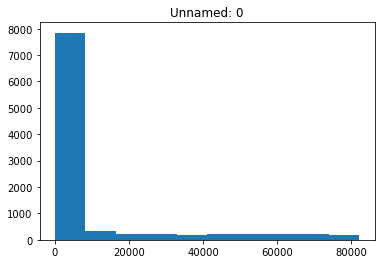

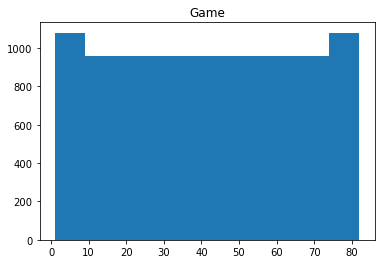

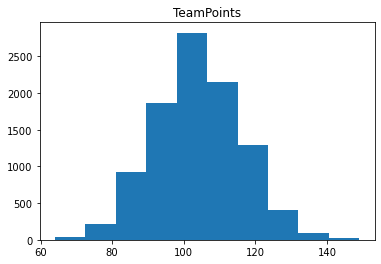

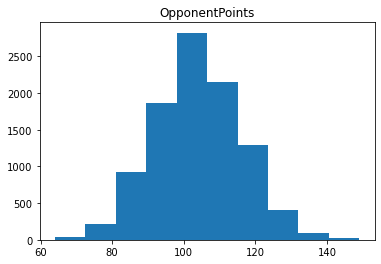

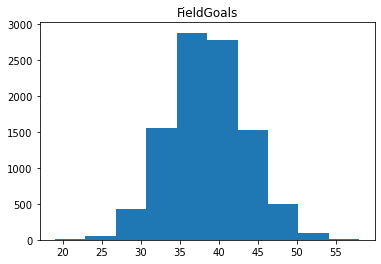

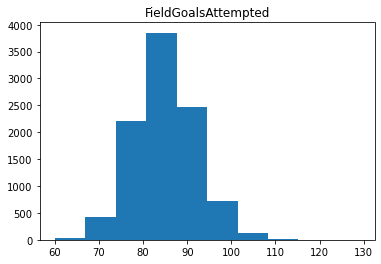

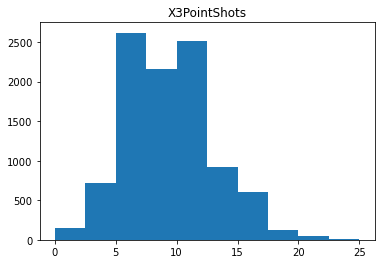

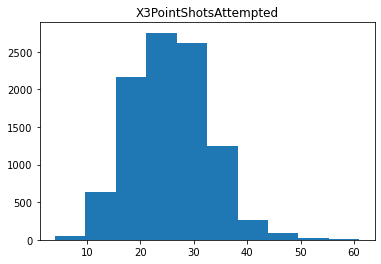

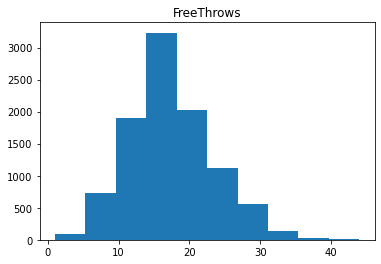

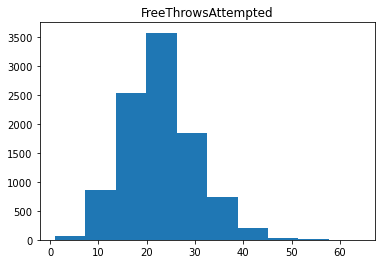

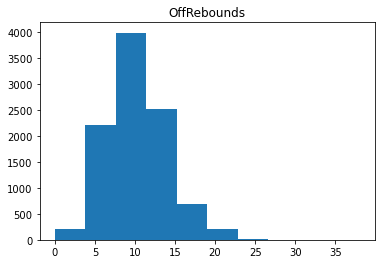

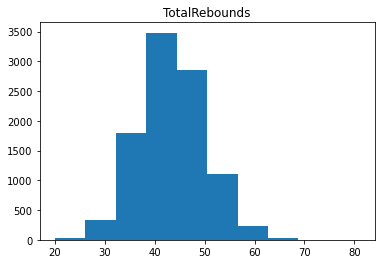

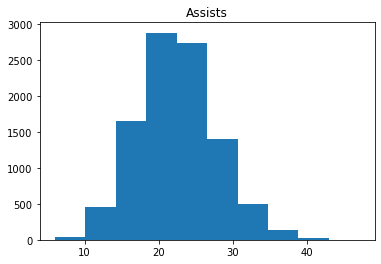

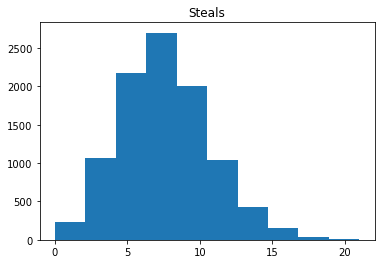

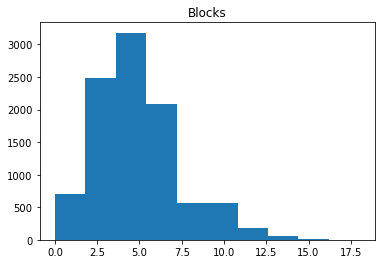

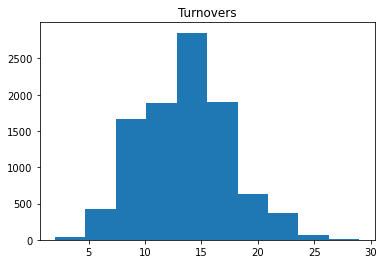

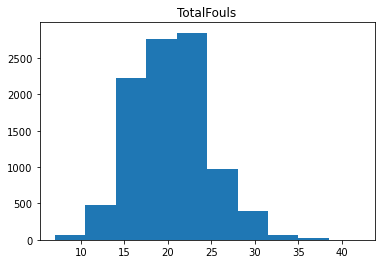

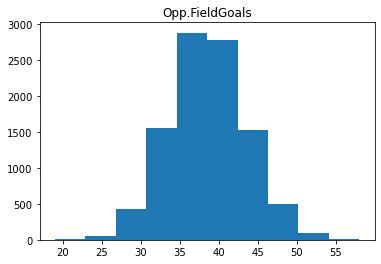

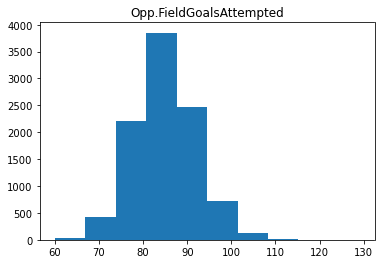

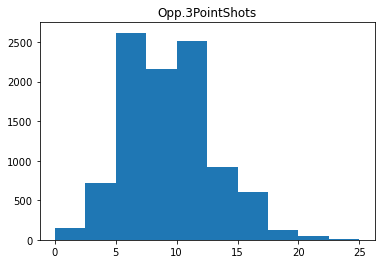

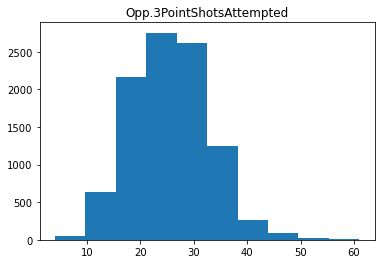

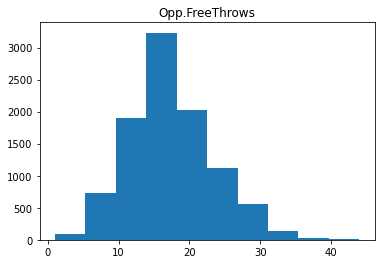

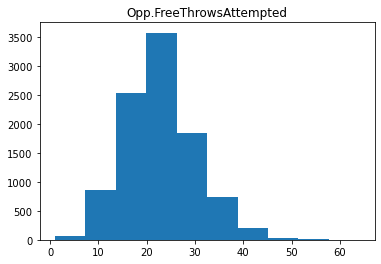

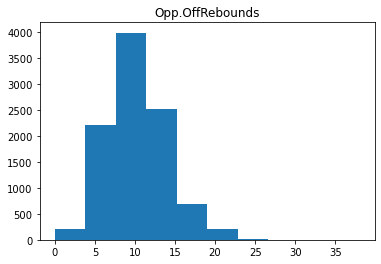

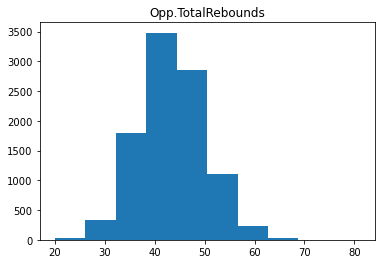

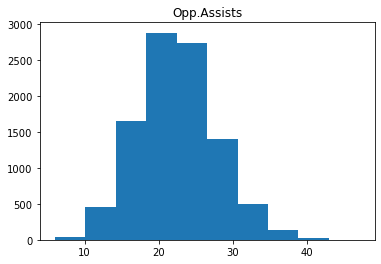

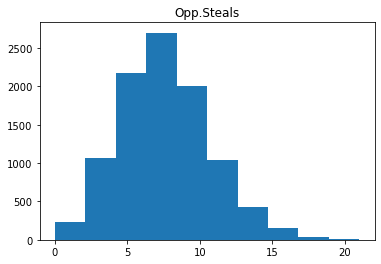

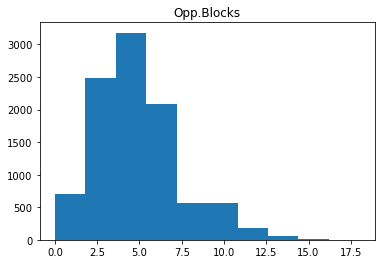

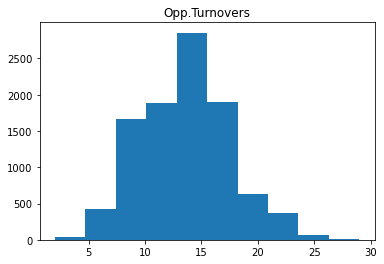

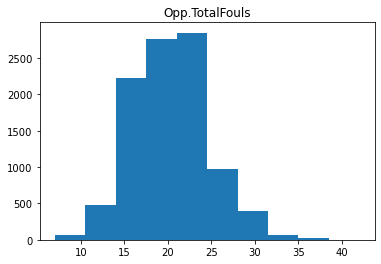

In [8]:
#checking plot distribution for all numerical columns
num_cols = nba.columns[[nba[col].dtype == 'int64' for col in nba.columns]]
for col in num_cols:
    plt.hist(nba[col])
    plt.title(col)
    plt.show()

<div class="alert alert-block alert-info"><b>Acquire Summary:</b>
    
* We will delete unnamed column because it wont be necessary
    
* We won't need game number because it will be in the index 
    
* Four seasons worth of data, we could look into splitting up the seasons 
    
* No null values, BIG PLUS! 
    
* Some outliers but its just a part of the game. Will keep all the data but could consider removing the outliers later 
    
* Normal distribution for all of the numerical columns
    
</div>

## Prepare

<div class="alert alert-block alert-info">
    
- adding two columns called home_is_west and away_is_west for teams playing in different conferences 
- Changed Home, Conference, Opp.Conference and Wins into dummy variables 
- dropped dates and columns that deal with point totals to not skew the models to predict who wins 
- split into train, validate and test
    
</div>

<div style="background-color:LightBlue">

- adding two columns called home_is_west and away_is_west for teams playing in different conferences 
- Changed Home, Conference, Opp.Conference and Wins into dummy variables 
- dropped dates and columns that deal with point totals to not skew the models to predict who wins 
- split into train, validate and test

</div>
